# 問題例の作成

In [384]:
class Timewindow():
    def __init__(self, e, l):
        self.e = e
        self.l = l

In [385]:
class Coordinate():
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [386]:
class Customer():
    def __init__(self, d, tw, coo, penalty, reward):
        self.demand = d
        self.tw = Timewindow(*tw)
        self.coordinate = Coordinate(*coo)
        self.penalty = penalty
        self.reward = reward

In [387]:
class Vehicle():
    def __init__(self, c, tour):
        self.capacity = c
        self.tour = tour

In [388]:
class piecewise_func():
    def __init__(self, e, l, interception, slope):
        self.e, self.l = e, l
        self.linear_func = lambda x : interception-(x-e)*slope
    def val(self, x):
        if x < self.e or self.l < x:
            return 0
        elif self.e <= x <= self.l:
            return self.linear_func(x)

In [389]:
class Reward_func():
    def __init__(self, interception, slope):
        self.interception = interception
        self.slope = slope

In [442]:
def ex():
    """
    V : 客集合
        N : 客数
        d : 需要
        tw : 時間枠
        (x, y) : 座標
        penalty : 時間枠を違反した場合にかかる、単位時間あたりの違反料
    K : 車両集合
        c : 容料
        #loading : 現在積んでいる荷物の量
        tour : 巡回路
    """
    import random
    random.seed(0)
    N = 5 #random.randint(5, 10)
    max_d = 10
    max_tw = 50
    max_co = 10
    max_slope = 3
    max_interception = 5
    V = {}
    sum_d = 0
    V[0] = Customer(0, [0,max_tw], (0,0), 0, piecewise_func(*(0, max_tw), *(0,0)))
    for i in range(1, N+1):
        d = random.uniform(-max_d, max_d)
        tw = sorted([random.uniform(0, max_tw) for i in range(2)])
        x, y = random.uniform(-max_co, max_co), random.uniform(-max_co, max_co)
        penalty = random.uniform(1, 10)
        slope = (-1)*random.uniform(0, max_slope)
        interception = random.uniform(0, max_interception) + (tw[1]-tw[0])*(-slope)
        reward = Reward_func(interception, slope)#piecewise_func(*tw, interception, slope)
        V[i] = Customer(d, tw, (x, y), penalty, reward)
        sum_d += d*(d>0)
        
    K = {}
    min_cap = max_d
    max_cap = max_d//1.2
    """
    M = 2 # random.randint(N//2, N*2)
    for k in range(M):
        c = random.uniform(min_cap, max_cap)
        K[k] = Vehicle(c, [])
    """
    sum_cap = 0
    i = 0
    while sum_cap<sum_d:
        c = random.uniform(min_cap, max_cap*1.5)
        K[i] = Vehicle(c, {})
        sum_cap += c
        i += 1
    #"""
    return V, K

In [443]:
def ex_small():
    """
    V : 客集合
        N : 客数
        d : 需要
        tw : 時間枠
        (x, y) : 座標
        penalty : 時間枠を違反した場合にかかる、単位時間あたりの違反料
    K : 車両集合
        c : 容料
        tour : 巡回路
    """
    import random
    random.seed(0)
    N = 5
    V = {}
    d_list = [0,1,-2,3,-4,5]
    tw_list = [(0,10),(0,10),(1,6),(2,8),(3,7),(4,7)]
    coo_list = [(0,0) for i in range(5+1)]#[(0,0),(0,2),(1,3),(2,6),(3,3),(4,10)]
    penalty_list = [0,10,10,10,20,20]
    linearfunc_list = [(0,0),(1,0),(2,0),(3,0),(4,0),(5,0)]
    V[0] = Customer(d_list[0], tw_list[0], coo_list[0], penalty_list[0], piecewise_func(*tw_list[0], *linearfunc_list[0]))
    for i in range(1,N+1):
        d = d_list[i]
        tw = tw_list[i]
        x, y = coo_list[i]
        penalty = penalty_list[i]
        reward = Reward_func(*linearfunc_list[i])#piecewise_func(*tw, *linearfunc_list[i])
        V[i] = Customer(d, tw, (x, y), penalty, reward)
        
    M = 3
    c_list = [2,4,6]
    K = {k:Vehicle(c_list[k], {}) for k in range(M)}
    K[0].tour = [0,1]
    K[1].tour = [0,2,3]
    K[2].tour = [0,4,5]
    
    return V, K

In [444]:
V, K = ex()

In [445]:
for i in V:
    print(i, end="\t")
    for condition in V[i].__dict__.values():
        print(condition, end="\n\t")
    print()

0	0
	0
	
1	6.888437030500963
	4.644407237053729
	
2	-0.4680609169528829
	7.802237837415015
	
3	8.194925119364804
	7.568485734341158
	
4	-0.5571456909457329
	9.699457309936829
	
5	-4.790153792160812
	4.589411880018419
	


In [446]:
for k in K:
    print(k, end="\t")
    for condition in K[k].__dict__.values():
        print(condition, end="\n\t")
    print()

0	10.002285638628857
	{}
	
1	10.987155732930649
	{}
	


In [447]:
sum(i.demand for i in V.values())

9.26800174980634

In [448]:
sum(i.capacity for i in K.values())

20.989441371559508

# 問題を解く

## 巡回路を生成  
先生のソルバーを使う

In [481]:
V, K = ex()

In [482]:
# 入力
## 顧客
C={} # 客の座標を保存する辞書
TW={} # 客の時間枠を保存する辞書
demand={} # 客の要求量(正の値は集荷，負の値は配達)
S={} # 客のサービス時間

for i in V:
    if i != 0:
        name="c"+str(i-1)
        x, y = V[i].coordinate.x, V[i].coordinate.y
        C[name] = (x,y)
        e, l = V[i].tw.e, V[i].tw.l
        TW[name] = (e,l)
        demand[name] = (V[i].demand, )
        S[name] = 0 #random.randint(10,20)
C["depot"]=(0,0)

## 車両
M = len(K) # number of vehicles
capacities = [(K[k].capacity, ) for k in range(M)] # capacity of vehicle

In [483]:
print("Customer",C)
print("Time Window",TW)
print("Demand",demand)
print("Service Time",S)

Customer {'c0': (-4.821664994140733, 0.22549442737217085), 'c1': (0.09373711634780513, -4.363243112005923), 'c2': (8.043319008791656, -3.797048613613347), 'c3': (2.217739468876033, 8.260221064757964), 'c4': (-9.719165996719621, 4.394093728079083), 'depot': (0, 0)}
Time Window {'c0': (21.02857904154225, 37.89772014701512), 'c1': (29.16910197275156, 45.40564425976676), 'c2': (40.51086179982948, 49.13927380188265), 'c3': (5.03506040341829, 21.708591772689186), 'c4': (27.434965191779465, 40.25139135065112)}
Demand {'c0': (6.888437030500963,), 'c1': (-0.4680609169528829,), 'c2': (8.194925119364804,), 'c3': (-0.5571456909457329,), 'c4': (-4.790153792160812,)}
Service Time {'c0': 0, 'c1': 0, 'c2': 0, 'c3': 0, 'c4': 0}


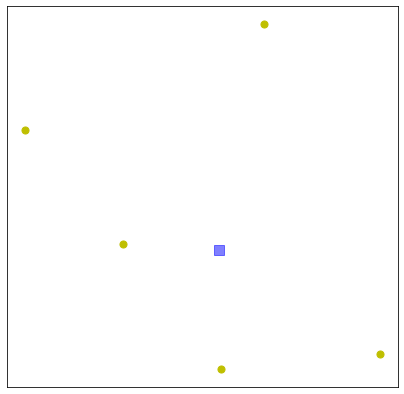

In [484]:
import networkx as nx
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(7,7))

G=nx.DiGraph()
nx.draw_networkx(G,pos=C,nodelist=[i for i in C if i != "depot"],node_color="y",node_size=50,with_labels=True,edge_color="k",width=1)
nx.draw_networkx(G,pos=C,nodelist=["depot"],node_color="blue",node_shape='s',alpha=0.5,node_size=100,with_labels=True,edge_color="k",width=1)

plt.show()

In [485]:
# 距離関数の定義
def Distance(t1,t2):
    return ((t1[0]-t2[0])**2+(t1[1]-t2[1])**2)**(0.5)

# ソルバーの読み込み
import sys
sys.path.append('..')

#from vrplib.vrp_d_1m1_t_model import *
import vrplib.vrp_d_1m1_t_model as vrp

# ソルバーの実行
model = vrp.Model("example") # モデルインスタンスの生成

## 客インスタンスの生成
for i in C:
    if i == "depot":
        continue
    model += vrp.Customer(i,demand=demand[i],timewindow=TW[i],servicetime=S[i])

## 車両インスタンスの生成
for k in range(M):
    model += vrp.Vehicle("v"+str(k),capacity=capacities[k])
    
## 枝インスタンスの生成
for i in C:
    for j in C:
        if i!=j:
            dist = time = Distance(C[i],C[j])
            model += vrp.Edge(i,j,dist,time)

In [486]:
## 最適化の実行
obj=model.optimize(IterLimit=100,TimeLimit=11,Verbose=False,OutputFlag=False)

## 得られた解の表示
print("objective value =",obj)
for v in model.vehiclesL:
    print()
    print(v)
    print(list(map(lambda x:x.name,v.routing[1:-1])))    
    for iv in map(lambda x:x.name,v.routing[1:-1]):
        print(iv)

objective value = 53.59

Vehicle v0: {'capacity': (10.002285638628857,)}
21.228493 = {'distance': 21.228493, 'freight_1M1': 0.0, 'timecost': 0.0}
['c1', 'c2']
c1
c2

Vehicle v1: {'capacity': (10.987155732930649,)}
32.358453 = {'distance': 32.358453, 'freight_1M1': 0.0, 'timecost': 0.0}
['c3', 'c4', 'c0']
c3
c4
c0


## 各車両の巡回路を保存

In [487]:
for v in model.vehiclesL:
    #print(K[v.name[1]])
    K[int(v.name[1])].tour = (0,) + tuple(map(lambda x:int(x.name[1])+1, v.routing[1:-1]))

In [488]:
for k in range(len(K)):
    print(K[k].tour)

(0, 2, 3)
(0, 4, 5, 1)


## 巡回路を評価（各顧客の出発時刻を決める）  
どのくらい時間がかかるか調べる

In [489]:
def distance(i, j, V):
    x0 = V[i].coordinate.x
    y0 = V[i].coordinate.y
    x1 = V[j].coordinate.x
    y1 = V[j].coordinate.y
    return ((x0-x1)**2 + (y0-y1)**2)**(1/2)

In [490]:
import gurobipy as gp

# インスタンスの生成
m = gp.Model("LP_for_VRP_small")

# 定数を設定
#V, K = ex() #ex_small()

# 変数を設定
"""
x_ik : 顧客iへ車両kが到着する時刻を表す変数
y_i : 車両が顧客iに到着する時刻が、顧客iの時間枠に対して、どの程度違反しているかを表す変数
z_i : 車両が顧客iに到着する時刻が、顧客iの時間枠に対して、どの程度嬉しいかを表す変数
"""
x = {(i,k):m.addVar(vtype=gp.GRB.CONTINUOUS, name=f"x({i},{k})") for k in K for i in K[k].tour}
y = {i:m.addVar(vtype=gp.GRB.CONTINUOUS, name=f"y({i})") for i in V}
#z = {i:m.addVar(vtype=gp.GRB.CONTINUOUS, name=f"z({i})") for i in V if i != 0}

m.update()

In [491]:
# 目的関数を設定
## 各顧客iの到着時刻x_ikと顧客iの時間枠を元に計算した違反料の和を最小化する
m.setObjective(gp.quicksum(V[i].penalty*y[i] for i in V), sense=gp.GRB.MINIMIZE)
#m.setObjectiveN(gp.quicksum(V[i].penalty*y[i] for i in V), 1)
#m.setObjectiveN(gp.quicksum(-1*z[i] for i in V if i != 0), 2)
"""
m.setObjectiveN(gp.quicksum(gp.quicksum(V[i].reward.val(x[i,k]) for i in K[k].tour) for k in K))
V[i].reward.val(x[i,k]) for k in K for i in K[k].tour
"""

'\nm.setObjectiveN(gp.quicksum(gp.quicksum(V[i].reward.val(x[i,k]) for i in K[k].tour) for k in K))\nV[i].reward.val(x[i,k]) for k in K for i in K[k].tour\n'

In [492]:
# 制約条件を設定
## 時間枠の違反に関する制約
for k in K:
    for i in K[k].tour:
        #m.addConstr(y[i,k] == penalty(i, x[i,k], V))
        m.addConstr(V[i].tw.e-y[i] <= x[i,k])
        m.addConstr(x[i,k] <= V[i].tw.l+y[i])
## 時間枠順守の嬉しさに関する制約
"""for k in K:
    for i in K[k].tour:
        if i != 0:
            #m.addConstr(V[i].reward.val(x[i,k]) <= z[i])
            #if V[i].tw.e <= x[i,k] <= V[i].tw.l:
            m.addConstr(V[i].reward.interception-(x[i,k]-V[i].tw.e)*V[i].reward.slope <= z[i])"""
## 任意の車両の巡回路内における、各顧客への到着時刻の先行、後行に関する制約
for k in K:
    for idx_p, i_p in enumerate(K[k].tour):
        for idx_f, i_f in enumerate(K[k].tour):
            if idx_p < idx_f:
                print(f"顧客{i_p}は顧客{i_f}よりも先に訪れられる")
                m.addConstr(x[i_p, k] + distance(i_p, i_f, V) <= x[i_f, k])
## 全ての車両はデポを出発し、サービス時間内に到着するという制約
for k in K:
    m.addConstr(0 <= x[0,k])

顧客0は顧客2よりも先に訪れられる
顧客0は顧客3よりも先に訪れられる
顧客2は顧客3よりも先に訪れられる
顧客0は顧客4よりも先に訪れられる
顧客0は顧客5よりも先に訪れられる
顧客0は顧客1よりも先に訪れられる
顧客4は顧客5よりも先に訪れられる
顧客4は顧客1よりも先に訪れられる
顧客5は顧客1よりも先に訪れられる


In [493]:
for k in range(M):
    print(K[k].tour)

(0, 2, 3)
(0, 4, 5, 1)


In [494]:
# 最適化
m.optimize()
                
# 解の表示
if m.Status == gp.GRB.OPTIMAL:
    for k in K:
        for i in K[k].tour:
            print(f"車両{k}が顧客{i}に到着する時刻は、{x[i, k].X}")
    print("最適値 : ", m.ObjVal)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 25 rows, 13 columns and 48 nonzeros
Model fingerprint: 0x792222a0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 5e+01]
Presolve removed 19 rows and 7 columns
Presolve time: 0.01s
Presolved: 6 rows, 6 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.556984e+01   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
車両0が顧客0に到着する時刻は、0.0
車両0が顧客2に到着する時刻は、29.16910197275156
車両0が顧客3に到着する時刻は、49.13927380188265
車両1が顧客0に到着する時刻は、0.0
車両1が顧客4に到着する時刻は、8.552755134486297
車両1が顧客5に到着する時刻は、27.434965191779465
車両1が顧客1に到着する時刻は、37.89772014701512
最適値 :  0.0
